# PCA

In [3]:
# imports
import os
import numpy as np
import pickle
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

%matplotlib inline

## PCA of HalfCheetah-v3 state space

Helper routines

In [4]:
def load_state_data(path):
    save_dict = pickle.load(open(path, "rb"))
    state_visit = save_dict["transitions"]
    return state_visit

def process_state_data(state_data):
    """
    :param state_data: dict mapping state to frequency.
    state is stored as raw bytes
    :returns: A matrix of all the unique states in state_data
    stacked vertically as a numpy array ( num_states x state_dim )
    """
    state_data = list(state_data.keys())
    state_data = [np.frombuffer(state, dtype=np.float32) for state in state_data]
    state_matrix = np.stack( state_data )
    return state_matrix
    
def plot_pca_results(state_matrix):
    """
    :param state_matrix: processed state data
    :outputs a plot of the cumulative explained variance
    vs number of components
    """
    pca = PCA().fit(state_matrix)
    sns.set(style="darkgrid", font_scale=1.0)
    fig, ax = plt.subplots(figsize=(10,5))
    ax.plot(np.cumsum(pca.explained_variance_ratio_))
    ax.set_xlabel('number of components')
    ax.set_ylabel('cumulative explained variance')
    ax.set_title('Cumulative Explained Variance vs. Number of Components')
    plt.show()
    
def run_pca(path):
    state_data = load_state_data(path)
    state_matrix = process_state_data(state_data)
    plot_pca_results(state_matrix)
    

Run PCA for seed1

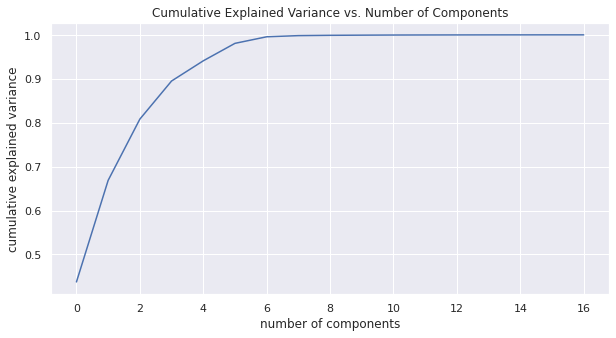

In [5]:
state_path = "results1/TD3_HalfCheetah-v3_seed1_batch0_trans.pkl"
run_pca(state_path)

# The End